Описание задания:
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

experimentVariant – вариант эксперимента

version – версия приложения

purchase – факт покупки

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from tqdm.auto import tqdm

In [70]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';')

In [72]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


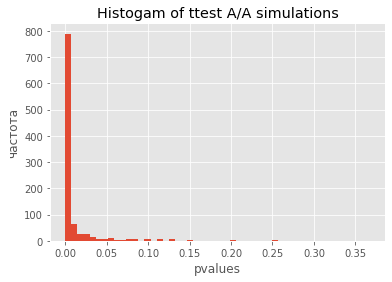

In [73]:
simulation = 1000 #количество симуляций
n_s = 1000 #количество наблюдений в подвыборке
rez = [] # сюда накапливаем результаты

# Запускаем симуляции для А/А теста
for i in tqdm(range(simulation)):
    a0 = df.query('experimentVariant == 0').purchase.sample(n_s, replace = False).values
    a1 = df.query('experimentVariant == 1').purchase.sample(n_s, replace = False).values
    rez.append(stats.ttest_ind(a0, a1, equal_var = False)[1])
    
plt.hist(rez, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('частота')
plt.title("Histogam of ttest A/A simulations")
plt.show()


In [74]:
sum(np.array(rez) < 0.05) / simulation # FPR

0.936

Ищем причину поломки сплит-системы

In [75]:
df.groupby(['experimentVariant', 'version']).purchase.count() 
# Проверяем, сколько в каждой А-ветке на каждую версию приходится пользователей всего. Тут соотношение ОК.

experimentVariant  version 
0                  v2.8.0      41283
                   v2.9.0      11921
                   v3.7.4.0     4204
                   v3.8.0.0     5694
1                  v2.8.0      41552
                   v2.9.0      12033
                   v3.7.4.0     4221
                   v3.8.0.0     6110
Name: purchase, dtype: int64

In [76]:
df.groupby(['experimentVariant', 'version']).purchase.sum()
# Проверяем, сколько в каждой А-ветке на каждую версию приходится пользователей, совершивших покупку.
# Здесь мы можем видеть, что в версии v2.8.0 в первой А-ветке чрезмерно низкое количество пользователей, совершивших покупку. 

experimentVariant  version 
0                  v2.8.0        41
                   v2.9.0       890
                   v3.7.4.0     252
                   v3.8.0.0     328
1                  v2.8.0      1895
                   v2.9.0       858
                   v3.7.4.0     266
                   v3.8.0.0     384
Name: purchase, dtype: int64

Сравним одну и ту же версию в каждой ветке через т-тест

In [77]:
stats.ttest_ind(df.query('version == "v2.8.0" and experimentVariant == 0').purchase.values, 
                df.query('version == "v2.8.0" and experimentVariant == 1').purchase.values)
# По данной версии эти две ветки сильно отличаются.

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

In [78]:
stats.ttest_ind(df.query('version == "v2.9.0" and experimentVariant == 0').purchase.values, 
                df.query('version == "v2.9.0" and experimentVariant == 1').purchase.values)
# Нет статистически значимого результата в выборках по данной версии.

Ttest_indResult(statistic=0.9979597634962479, pvalue=0.31830895167207446)

In [79]:
stats.ttest_ind(df.query('version == "v3.7.4.0" and experimentVariant == 0').purchase.values, 
                df.query('version == "v3.7.4.0" and experimentVariant == 1').purchase.values)
# Нет статистически значимого результата в выборках по данной версии.

Ttest_indResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735)

In [80]:
stats.ttest_ind(df.query('version == "v3.8.0.0" and experimentVariant == 0').purchase.values, 
                df.query('version == "v3.8.0.0" and experimentVariant == 1').purchase.values)
# Нет статистически значимого результата в выборках по данной версии.

Ttest_indResult(statistic=-1.1956188950206779, pvalue=0.23186933664059722)

Т-тест подтверждает, что причина поломки в мобильной версии v2.8.0. 
Выбросим данную версию из исходного датафрейма и проведем А/А тест заново.

In [81]:
df = df.query('version != "v2.8.0"')

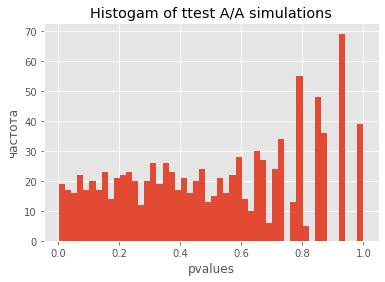

0.045

In [82]:
simulation = 1000 #количество симуляций
n_s = 1000 #количество наблюдений в подвыборке
rez = [] # сюда накапливаем результаты

# Запускаем симуляции для А/А теста
for i in tqdm(range(simulation)):
    a0 = df.query('experimentVariant == 0').purchase.sample(n_s, replace = False).values
    a1 = df.query('experimentVariant == 1').purchase.sample(n_s, replace = False).values
    rez.append(stats.ttest_ind(a0, a1, equal_var = False)[1])
    
plt.hist(rez, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('частота')
plt.title("Histogam of ttest A/A simulations")
plt.show()

sum(np.array(rez) < 0.05) / simulation # FPR

#  PERFECT!